# Load library and data

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

ticker = 'PLTR'

# Download price data
raw = yf.download(ticker, start='2019-01-01',
                               multi_level_index=False,
                               auto_adjust=True)

# Display the first 5 rows
raw.head()

[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2020-09-30,9.50,11.41,9.11,10.00,338584400
2020-10-01,9.46,10.10,9.23,9.69,124297600
2020-10-02,9.20,9.28,8.94,9.06,55018300
2020-10-05,9.03,9.49,8.92,9.43,36316900
2020-10-06,9.90,10.18,8.90,9.04,90864000


# Data inspection

In [2]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1126 entries, 2020-09-30 to 2025-03-25
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1126 non-null   float64
 1   High    1126 non-null   float64
 2   Low     1126 non-null   float64
 3   Open    1126 non-null   float64
 4   Volume  1126 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 52.8 KB


In [3]:
if raw.isna().sum().any() or raw.isnull().sum().any():
    print('There are missing values in the dataset')
else:
    print('There are no missing values in the dataset')

There are no missing values in the dataset


In [4]:
raw.describe().T

,count,mean,std,min,25%,50%,75%,max
Close,1126.0,2.343464e+01,1.953443e+01,6.00,1.054250e+01,1.897500e+01,2.536500e+01,1.246200e+02
High,1126.0,2.406735e+01,2.007486e+01,6.17,1.099125e+01,1.959000e+01,2.607375e+01,1.254100e+02
Low,1126.0,2.274599e+01,1.882553e+01,5.92,1.023750e+01,1.852000e+01,2.454625e+01,1.184300e+02
Open,1126.0,2.339834e+01,1.945345e+01,5.98,1.054000e+01,1.901000e+01,2.538000e+01,1.238600e+02
Volume,1126.0,5.742679e+07,4.216519e+07,9126400.00,3.280052e+07,4.500300e+07,6.547712e+07,4.502905e+08


# Train Test Split

In [5]:
import pandas as pd

def ensure_datetime_index(df):
    """Ensures that the DataFrame index is a DatetimeIndex and returns it."""
    if df is not None and not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    return df


def time_series_split(df, split_ratio=0.8):
    """Splits data for training and testing."""
    df = ensure_datetime_index(df)
    split_idx = int(len(df) * split_ratio)

    # Train-test split
    train_df = df.iloc[:split_idx]
    test_df = df.iloc[split_idx:]

    return train_df, test_df


def resample_data(df, resample_period='daily', resample_method='last'):
    """
    Resamples the dataset based on the given period and aggregation method.
    """
    # Valid resampling periods and methods
    valid_periods = {'daily': 'D', 'weekly': 'WE', 'monthly': 'ME', 'quarterly': 'QE', 'yearly': 'YE'}
    valid_methods = {'mean': 'mean', 'min': 'min', 'max': 'max', 'median': 'median', 'last': 'last'}

    if resample_period not in valid_periods:
        raise ValueError(f"Invalid resample period: {resample_period}. Choose from {list(valid_periods.keys())}")

    if resample_method not in valid_methods:
        raise ValueError(f"Invalid resample method: {resample_method}. Choose from {list(valid_methods.keys())}")

    # If daily, do not resample
    if resample_period == 'daily':
        return df

    # Perform resampling
    if resample_method == 'last':
        resampled_df = df.resample(valid_periods[resample_period]).last()
    else:
        resampled_df = df.resample(valid_periods[resample_period]).agg(valid_methods[resample_method])

    return resampled_df.dropna()  # Drop NaNs that may appear due to resampling


def split_ts_resample(df, resample_period='daily', resample_method='last', split_ratio=0.8):
    """
    Splits the time series data and resamples it.
    """
    train_df, test_df = time_series_split(df, split_ratio)

    # Resample both train and test sets
    train_resample = resample_data(train_df, resample_period, resample_method)
    test_resample = resample_data(test_df, resample_period, resample_method)

    return train_resample, test_resample


In [6]:
train_df, test_df = time_series_split(raw, split_ratio=0.9)
print(f'Train shape: {train_df.shape}')
print(f'Test shape: {test_df.shape}')

Train shape: (1013, 5)
Test shape: (113, 5)


# EDA

## Price plot

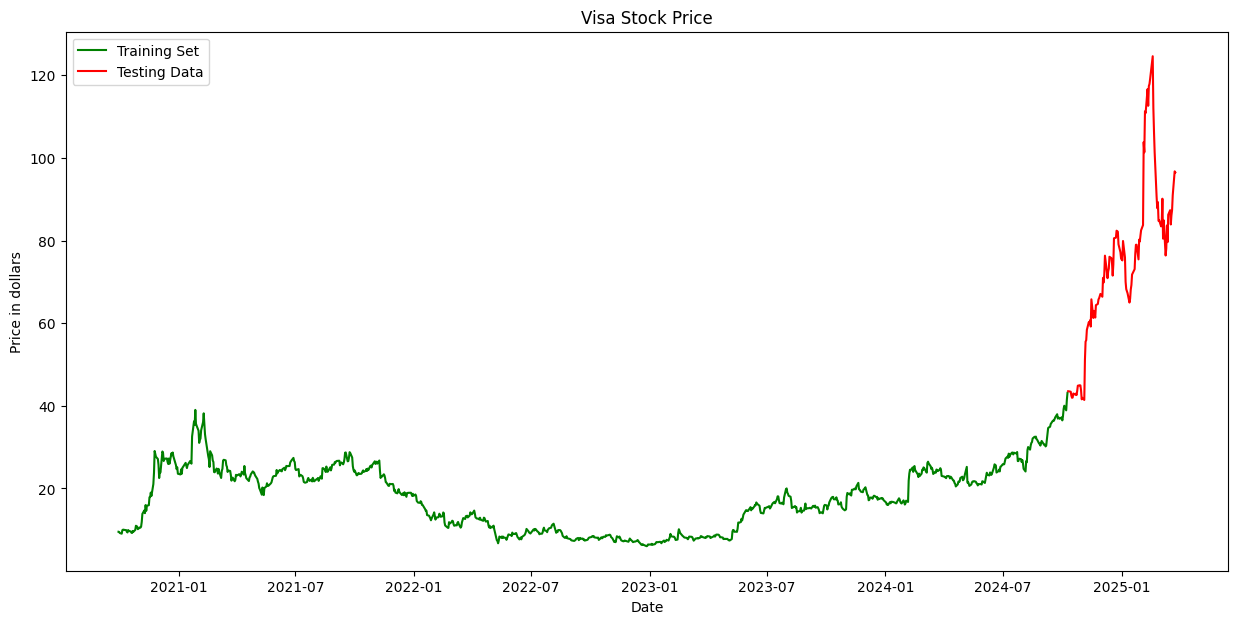

In [7]:
import matplotlib.pyplot as plt

# Plot Train and Test set
plt.figure(figsize=(15, 7))
plt.title('Visa Stock Price')
plt.xlabel('Date')
plt.ylabel('Price in dollars')
plt.plot(train_df['Close'], 'green')
plt.plot(test_df['Close'], 'red')
plt.legend(['Training Set', 'Testing Data'])
plt.show()

## Log returns

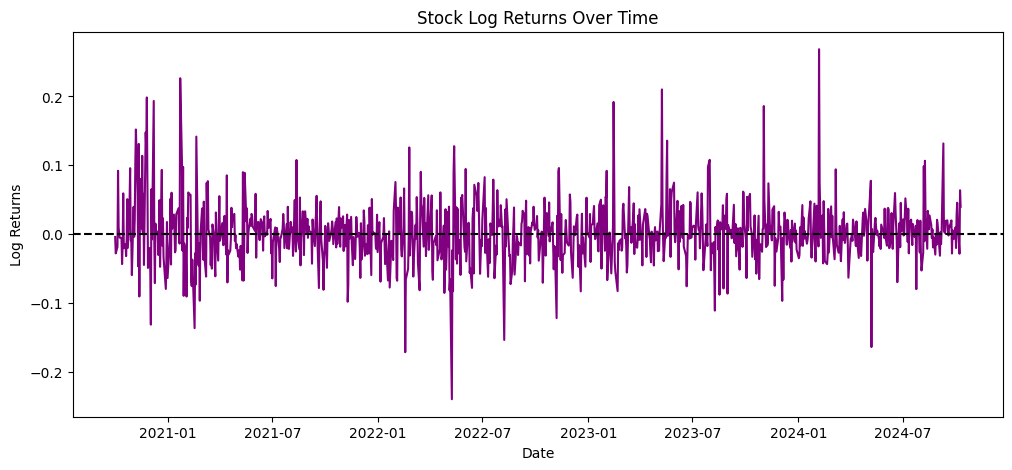

In [8]:
# Compute daily log returns
log_ret = np.log(train_df['Close'] / train_df['Close'].shift(1))
ret = train_df['Close'].pct_change()

# Plot log returns
plt.figure(figsize=(12, 5))
plt.plot(train_df.index, log_ret, color='purple', linewidth=1.5)
plt.axhline(y=0, color='black', linestyle='dashed')  # Baseline at 0
plt.xlabel("Date")
plt.ylabel("Log Returns")
plt.title("Stock Log Returns Over Time")
plt.show()


## Log return's distribution

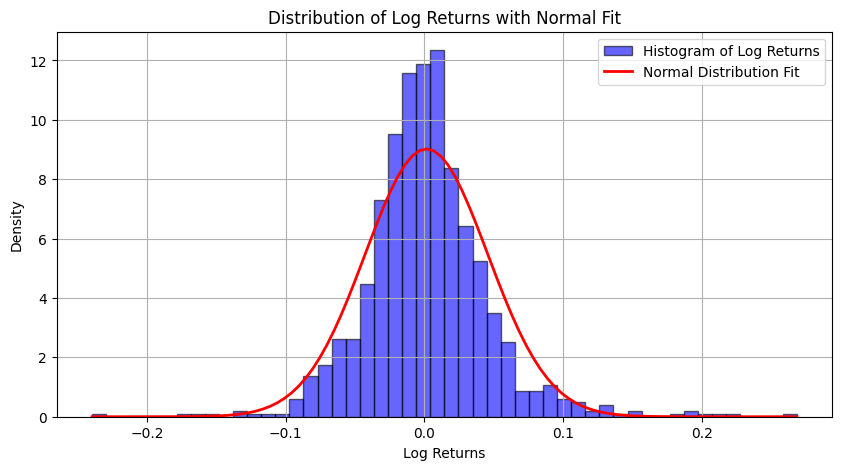

In [9]:
from scipy.stats import norm

# Create a range of x values for the normal distribution
x_list = np.linspace(log_ret.min(), log_ret.max(), 100)

# Compute the normal distribution PDF using mean & standard deviation
y_list = norm.pdf(x_list, loc=log_ret.mean(), scale=log_ret.std())

# Plot histogram of log returns
plt.figure(figsize=(10, 5))
log_ret.hist(bins=50, density=True, alpha=0.6, color="blue", edgecolor="black", label="Histogram of Log Returns")

# Plot normal distribution curve
plt.plot(x_list, y_list, color='red', linewidth=2, label="Normal Distribution Fit")

# Labels & title
plt.xlabel("Log Returns")
plt.ylabel("Density")
plt.title("Distribution of Log Returns with Normal Fit")
plt.legend()
plt.show()

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_price_change(df, ticker, resample_period=None, resample_method=None):
    """
    Plots stock price changes as absolute differences and percentage changes.
    """
    # Apply resampling if needed
    if resample_period and resample_method:
        temp = resample_data(df, resample_period=resample_period, resample_method=resample_method)
    else:
        temp = df.copy()

    # Define display period label
    display = resample_period.capitalize() if resample_period else 'Daily'

    # Compute price changes
    temp['ret'] = temp['Close'].pct_change()
    temp['diff'] = temp['Close'].diff()

    # Drop NaN values
    bar_df = temp[['diff', 'ret']].dropna().reset_index()

    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    # Assign colors properly for price changes
    bar_color = ['green' if x > 0 else 'red' for x in bar_df['diff']]
    bar_pct_color = ['green' if x > 0 else 'red' for x in bar_df['ret']]

    # Absolute Price Change (diff)
    axes[0].bar(bar_df.index, bar_df['diff'], color=bar_color)
    axes[0].set_xlabel('Period')
    axes[0].set_ylabel('Price Change ($)')
    axes[0].set_title(f"{ticker} {display} Price Change (Diff)")
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(True)

    # Percentage Returns (PCT)
    axes[1].bar(bar_df.index, bar_df['ret'], color=bar_pct_color)
    axes[1].set_xlabel('Period')
    axes[1].set_ylabel('Percentage Change (%)')
    axes[1].set_title(f"{ticker} {display} Returns (%)")
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

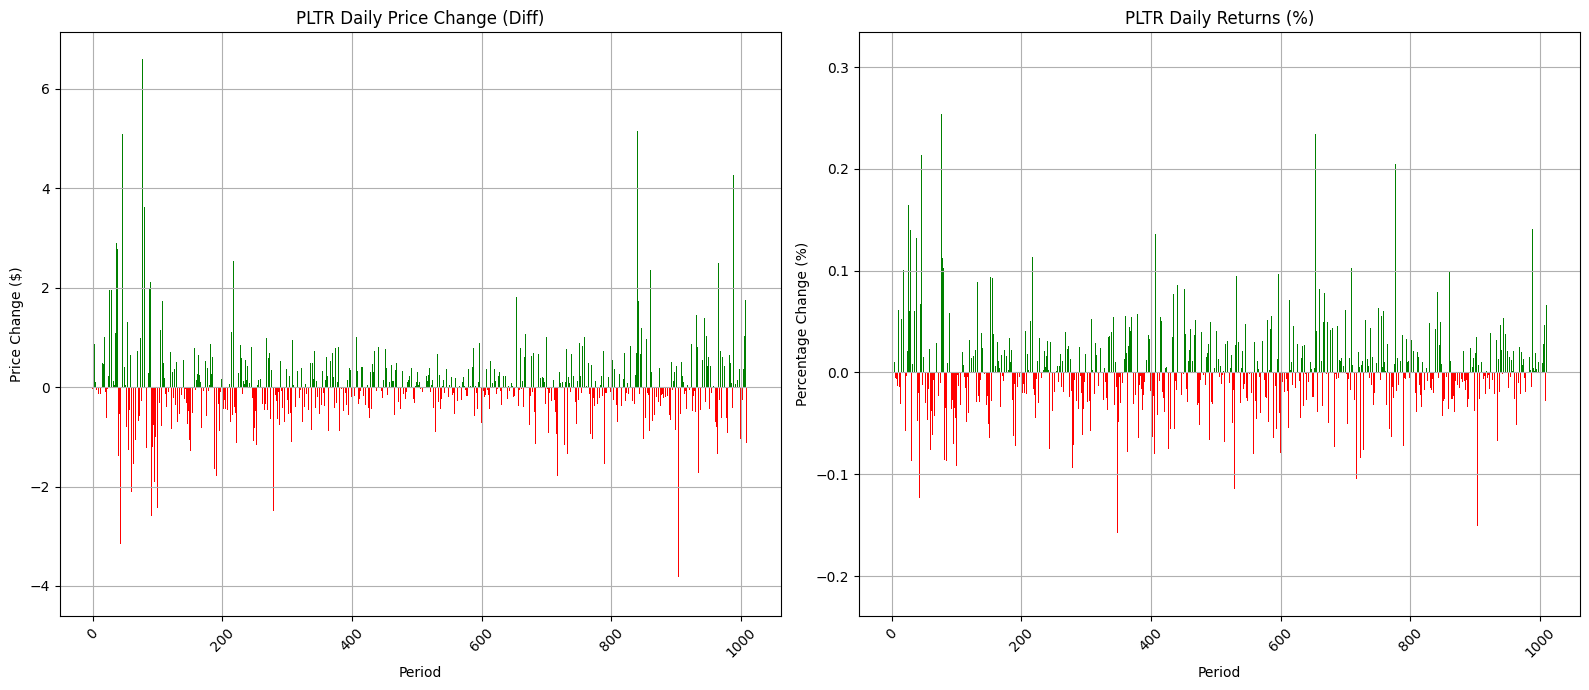

In [11]:
plot_price_change(train_df, ticker=ticker)

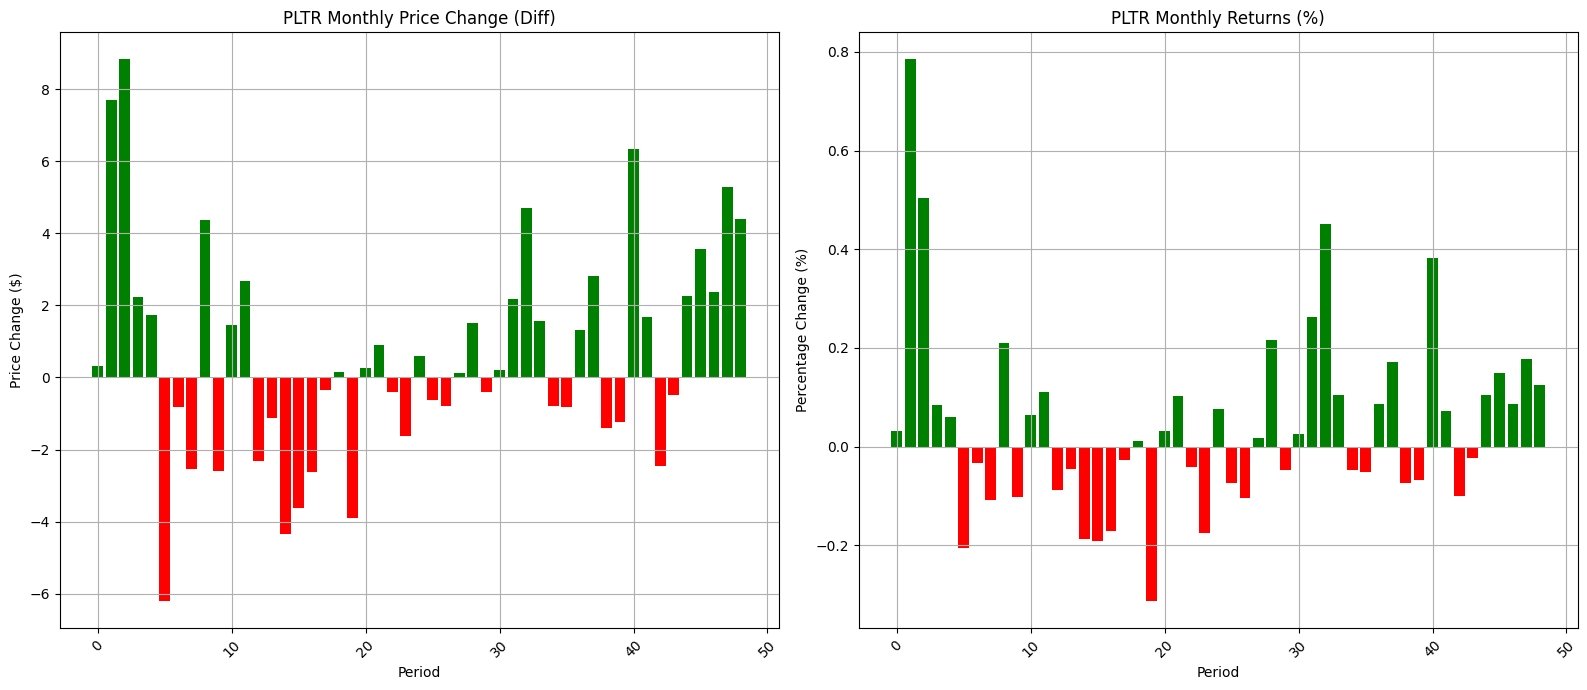

In [12]:
plot_price_change(train_df, ticker=ticker, resample_period='monthly', resample_method='mean')

## Monthly plot

In [13]:
from posixpath import split
from statsmodels.graphics.tsaplots import month_plot, quarter_plot

def mth_qtr_plot(df, split_ts=None, split_ratio=0.8, resample=None, resample_method=None):
    """
    Function to generate monthly or quarterly seasonality plots.
    """
    # Validate resampling choice
    if resample not in ['monthly', 'quarterly']:
        raise ValueError("Invalid resample value. Choose 'monthly' or 'quarterly'.")

    # Train-test split if required
    if split_ts:
        train_df, test_df = split_ts_resample(df, resample, split_ratio=split_ratio, resample_method=resample_method)
    else: train_df = resample_data(df, resample, resample_method)

    #
    if resample == 'monthly':
        month_plot(train_df)
    elif resample == 'quarterly':
        quarter_plot(train_df)


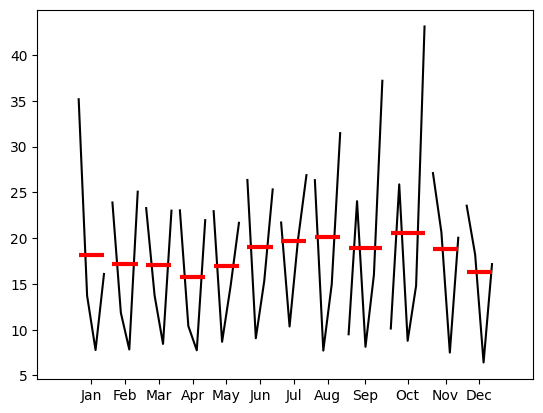

In [14]:
mth_qtr_plot(train_df['Close'], split_ts=None, resample='monthly', resample_method='last')

## Quarterly plot

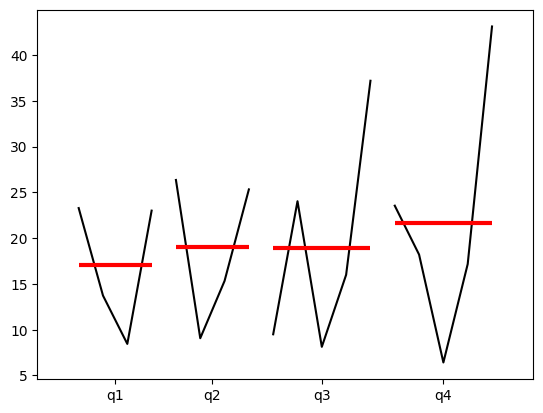

In [15]:
mth_qtr_plot(train_df['Close'], split_ts=None, resample='quarterly', resample_method='last')

## Seasonal decomposition

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

def seasonal_decompose_subplot(df, stock, split_ts=None, split_ratio=0.8, resample=None, resample_method=None):

    # Ensure correct period selection
    valid_periods = {'daily': 30, 'weekly': 7, 'monthly': 12, 'quarterly': 4, 'yearly': 1}
    if resample not in valid_periods:
        raise ValueError("Invalid resample value. Choose 'daily', 'weekly', 'monthly', 'quarterly', or 'yearly'.")

    # Train/test split and resampling logic
    if split_ts and resample:
        train_df, test_df = split_ts_resample(df, resample, split_ratio=split_ratio, resample_method=resample_method)
    elif split_ts:
        train_df, test_df = time_series_split(df, split_ratio=split_ratio)
    elif resample and resample_method is not None:
        train_df = resample_data(df, resample, resample_method)
    else:
        train_df = df.copy()

    # Seasonal decomposition
    period = valid_periods[resample]
    add_model = seasonal_decompose(train_df[stock], model='additive', period=period)
    mul_model = seasonal_decompose(train_df[stock], model='multiplicative', period=period)

    # Subplot
    fig, axes = plt.subplots(4, 2, figsize=(16, 15))

    # Titles
    axes[0, 0].set_title("Additive Model")
    axes[0, 1].set_title("Multiplicative Model")

    # Plot each component (Observed, Trend, Seasonal, Residual)
    components = ["observed", "trend", "seasonal", "resid"] # attribute names
    component_labels = ["Observed", "Trend", "Seasonal", "Residual"] # legends

    for i, comp in enumerate(components):
        # Left (Additive)
        axes[i, 0].plot(getattr(add_model, comp), label=f"Additive {component_labels[i]}")
        axes[i, 0].legend()

        # Right (Multiplicative)
        axes[i, 1].plot(getattr(mul_model, comp), label=f"Multiplicative {component_labels[i]}")
        axes[i, 1].legend()

    plt.tight_layout()
    plt.show()

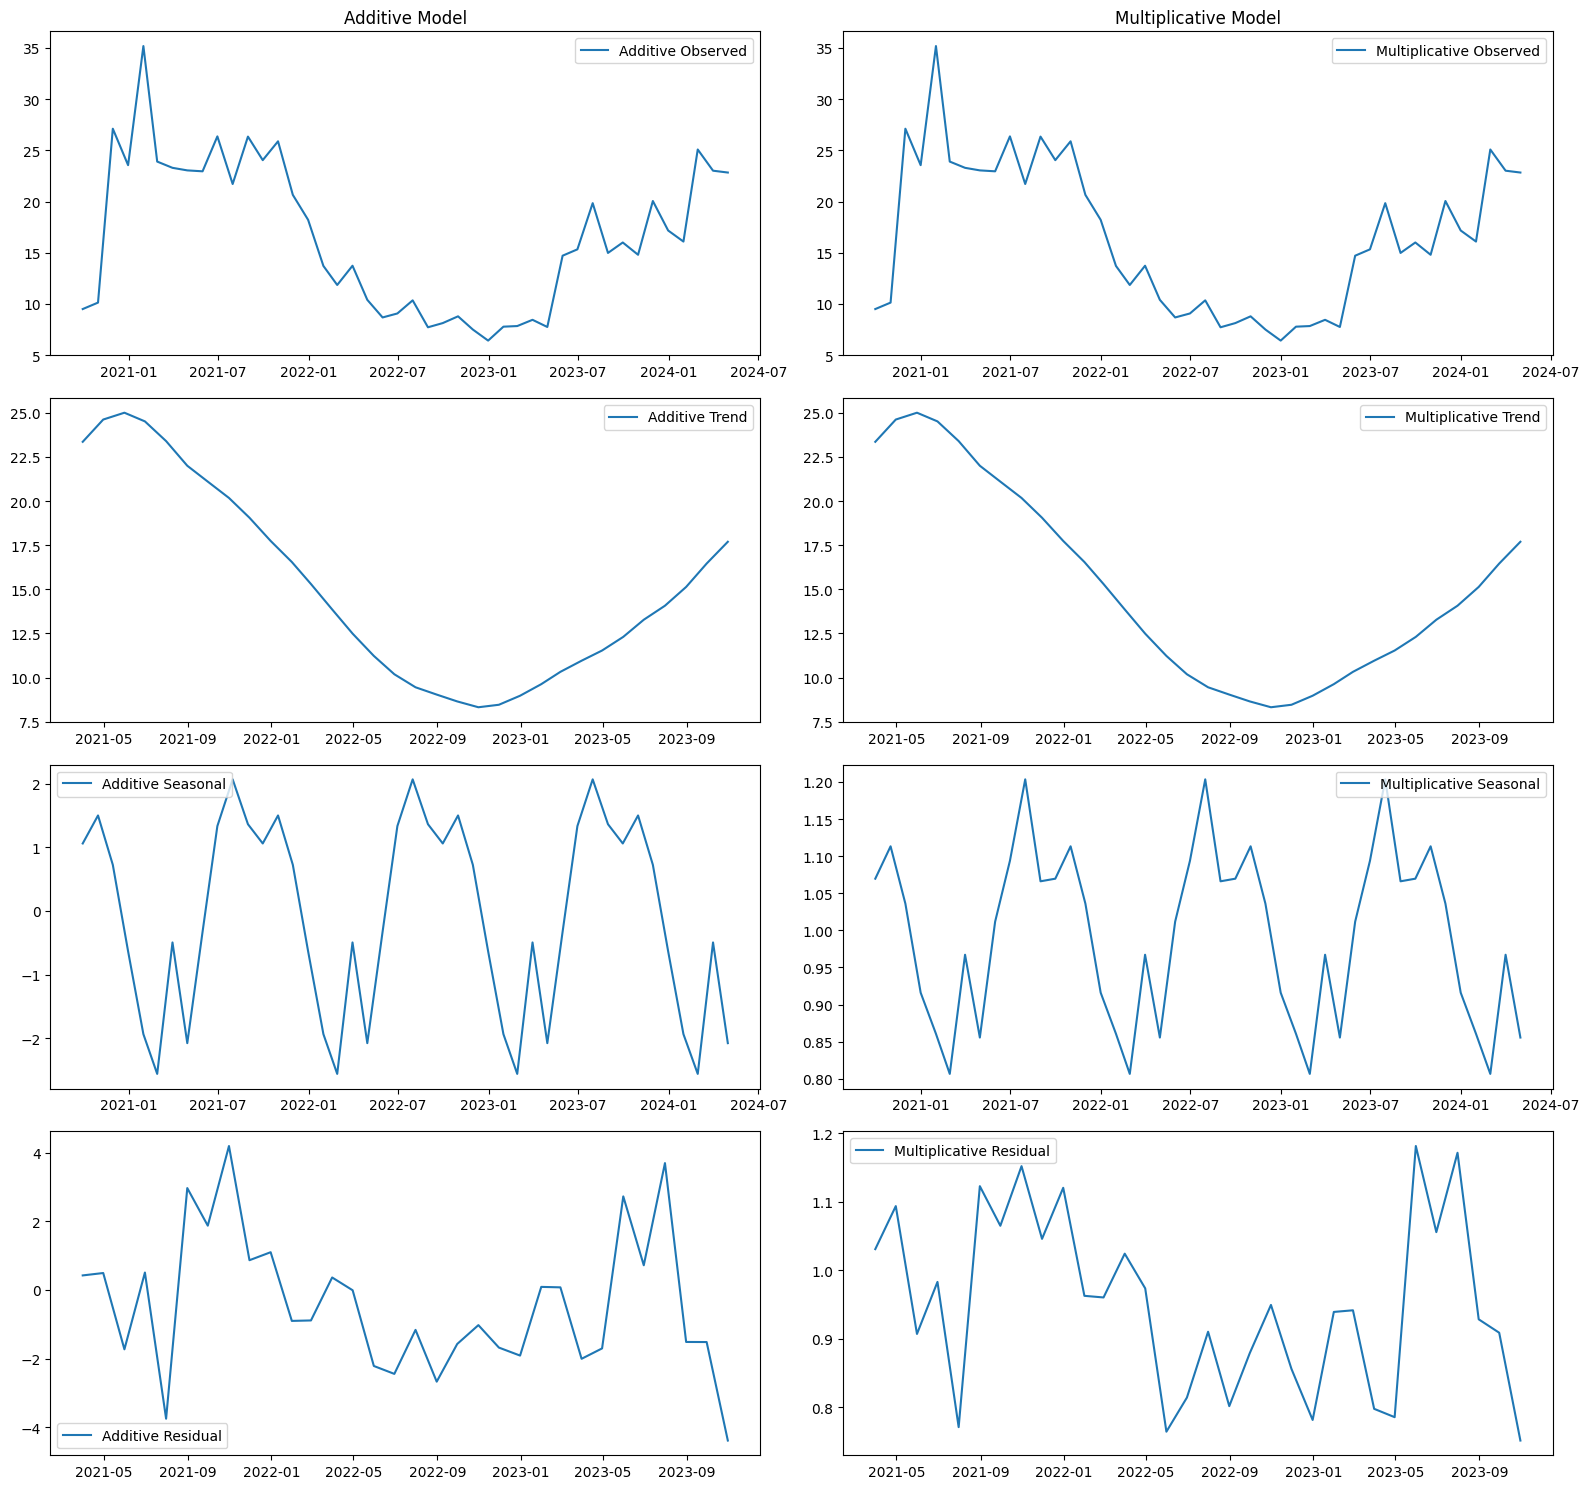

In [17]:
seasonal_decompose_subplot(raw, 'Close', split_ts=True,
                           resample='monthly', resample_method='last')

## ACF

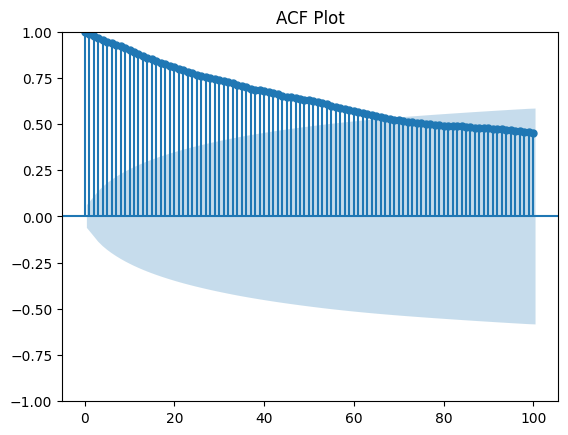

In [18]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(train_df['Close'], lags=100)
plt.title(f"ACF Plot")
plt.show()

## PACF

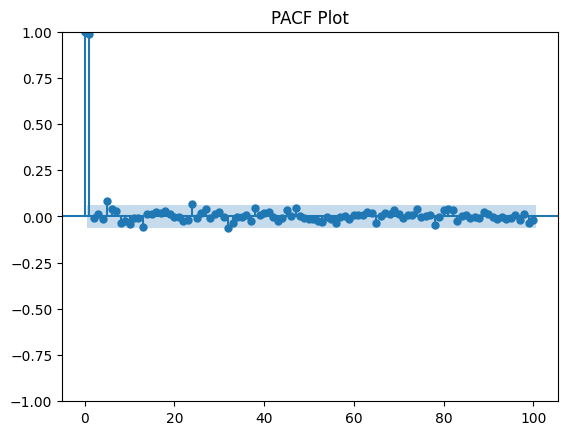

In [19]:
from statsmodels.graphics.tsaplots import plot_pacf


plot_pacf(train_df['Close'], lags=100)
plt.title(f"PACF Plot")
plt.show()

# ARIMA

## AR Term (p) parameter tuning

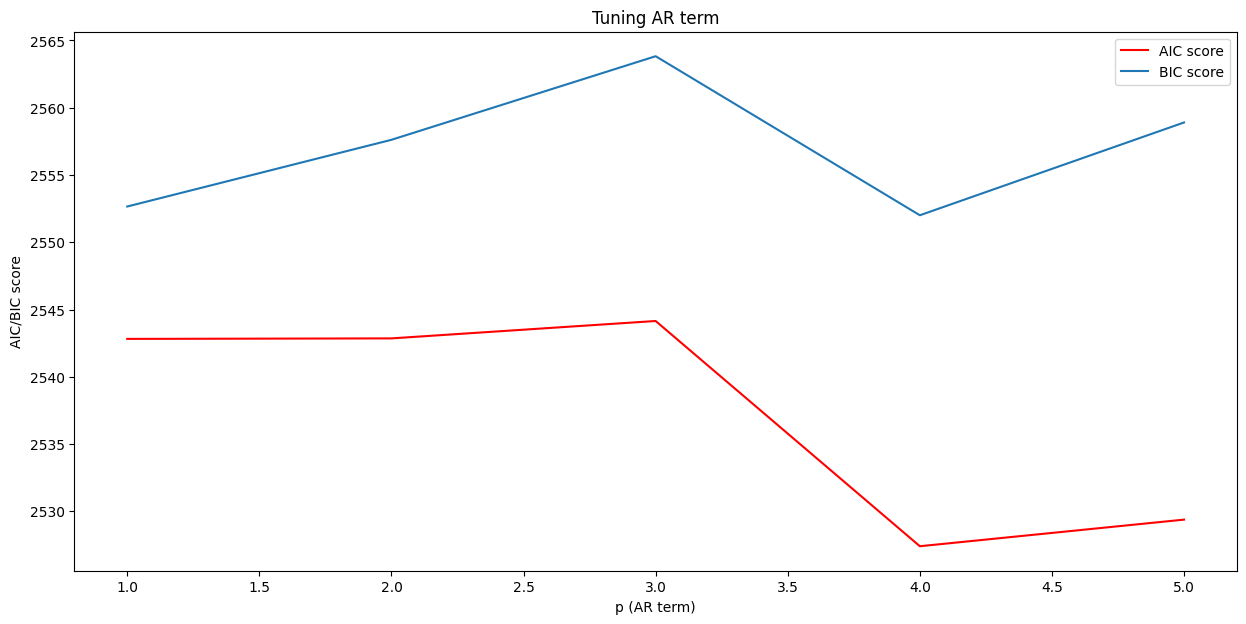

In [20]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Import ARIMA
from statsmodels.tsa.arima.model import ARIMA

# Empty list to store aic/bic score
aic_p = []
bic_p = []

# p values
p = range(1, 6)  # [1,2,3,4,5]

# AIC/BIC score for different values of p
for i in p:
    # Define the AR model
    model = ARIMA(train_df['Close'], order=(i, 1, 0))
    # Fit the model
    model_fit = model.fit()
    # Get AIC score
    aic_temp = model_fit.aic
    # Get BIC score
    bic_temp = model_fit.bic
    # Append AIC score
    aic_p.append(aic_temp)
    # Append BIC score
    bic_p.append(bic_temp)

# Plot of AIC/BIC score for AR term
plt.figure(figsize=(15, 7))
plt.plot(range(1, 6), aic_p, color='red')
plt.plot(range(1, 6), bic_p)
plt.title('Tuning AR term')
plt.xlabel('p (AR term)')
plt.ylabel('AIC/BIC score')
plt.legend(['AIC score', 'BIC score'])
plt.show()

## MA Term (q) parameter tuning

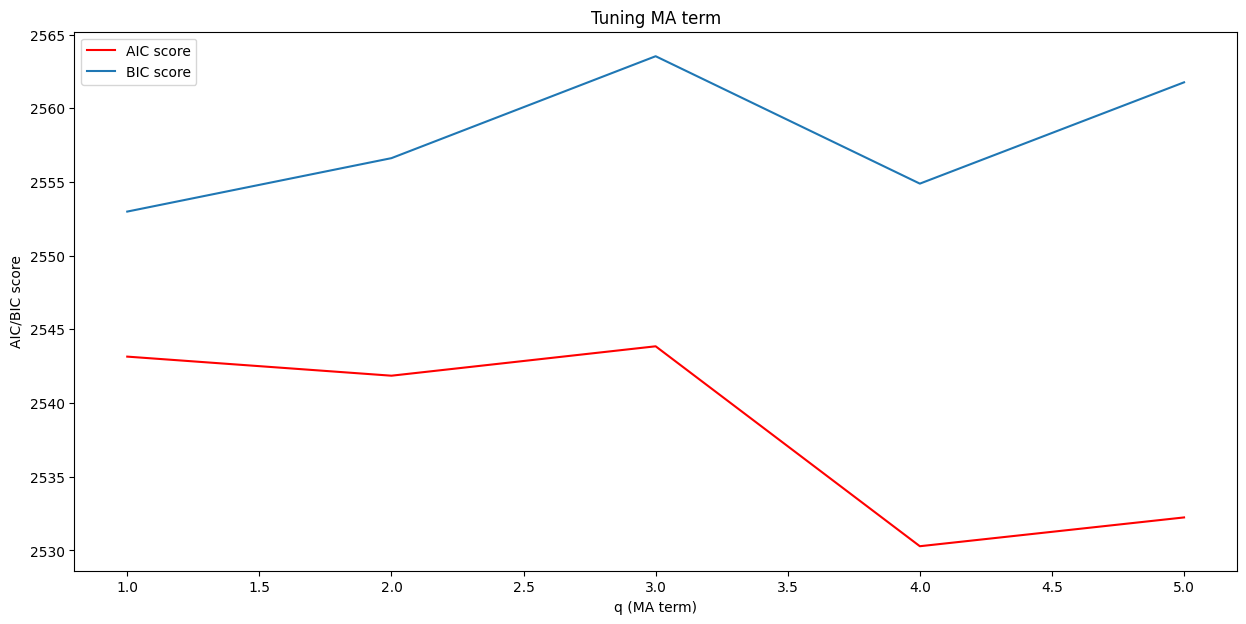

In [21]:
# Empty list to store AIC/BIC score
aic_q = []
bic_q = []

# q values
q = range(1, 6)

# AIC/BIC score for different values of q
for i in q:
    model = ARIMA(train_df['Close'], order=(0, 1, i))
    model_fit = model.fit()
    aic_temp = model_fit.aic
    bic_temp = model_fit.bic
    aic_q.append(aic_temp)
    bic_q.append(bic_temp)

# Plot of AIC/BIC score for MA term
plt.figure(figsize=(15, 7))
plt.plot(range(1, 6), aic_q, color='red')
plt.plot(range(1, 6), bic_q)
plt.title('Tuning MA term')
plt.xlabel('q (MA term)')
plt.ylabel('AIC/BIC score')
plt.legend(['AIC score', 'BIC score'])
plt.show()

## Auto tuning

In [22]:
# import pandas as pd
# from itertools import product
# from statsmodels.tsa.arima.model import ARIMA

# def ARIMA_hyperparameter(df, summary=False):
#     """
#     Find the best ARIMA (p,d,q) parameters based on the lowest AIC.

#     Parameters:
#     df (pd.Series): Time series data.
#     summary (bool): If True, return a DataFrame with all (p,d,q) combinations and their AIC scores.

#     Returns:
#     tuple: Best (p,d,q) parameters and optionally a DataFrame with AIC values.
#     """
#     aic = []
#     p_q_d = []

#     p = range(0, 6)
#     d = range(0, 3)  # Typically, d=1 is sufficient for most cases
#     q = range(0, 6)

#     pdq_combinations = list(product(p, d, q))

#     best_aic = float("inf")
#     best_params = None

#     for param in pdq_combinations:
#         try:
#             # Fit ARIMA model
#             model = ARIMA(df, order=param).fit()
#             aic_value = model.aic

#             p_q_d.append(param)
#             aic.append(aic_value)

#             if aic_value < best_aic:
#                 best_aic = aic_value
#                 best_params = param
#         except Exception as e:
#             print(f"Skipping {param} due to error: {e}")  # More informative error handling

#     if summary:
#         df_aic = pd.DataFrame({'p_q_d': p_q_d, 'aic': aic}).sort_values(by='aic', ascending=True).reset_index(drop=True)
#         return best_params, df_aic

#     return best_params


In [23]:
# ARIMA_hyperparameter(train_df['Close'], summary=True)

## Rolling forecast

In [24]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# Convert pandas series to lists for rolling window forecast
past = train_df['Close'].tolist()
test_set = test_df['Close'].tolist()

# Empty lists for storing predictions
test_pred = []
ci_intervals = []

# Perform rolling window forecast
for i in range(len(test_set)):
    # Define and fit ARIMA model
    model = ARIMA(past, order=(4,1,4))
    model_fit = model.fit()

    # Make forecasts
    # yhat = model_fit.forecast()[0]  # Standard forecast
    forecast_result = model_fit.get_forecast()  # Forecast with intervals
    yhat = forecast_result.predicted_mean  # Equivalent to yhat
    ci = forecast_result.conf_int()  # Confidence intervals

    # Store predictions
    test_pred.append(yhat)
    ci_intervals.append(ci.flatten())  # Convert to array

    # Add test value to train set for rolling forecast
    past.append(test_set[i])

# Convert confidence intervals to DataFrame
ci_df = pd.DataFrame(ci_intervals, columns=['Lower Bound', 'Upper Bound'], index=test_df.index)

# Create DataFrame for results
arima_df = pd.DataFrame(data=raw, index=raw.index)
arima_df['Prediction'] = np.nan
arima_df.loc[train_df.index, 'Prediction'] = train_df['Close']
arima_df.loc[test_df.index, 'Prediction'] = test_pred

# Merge confidence intervals into test DataFrame
arima_df = arima_df.join(ci_df)
arima_df

,Close,High,Low,Open,Volume,Prediction,Lower Bound,Upper Bound
Date,,,,,,,,
2020-09-30,9.500000,11.410000,9.110000,10.000000,338584400,9.500000,NaN,NaN
2020-10-01,9.460000,10.100000,9.230000,9.690000,124297600,9.460000,NaN,NaN
2020-10-02,9.200000,9.280000,8.940000,9.060000,55018300,9.200000,NaN,NaN
2020-10-05,9.030000,9.490000,8.920000,9.430000,36316900,9.030000,NaN,NaN
2020-10-06,9.900000,10.180000,8.900000,9.040000,90864000,9.900000,NaN,NaN
...,...,...,...,...,...,...,...,...
2025-03-19,86.099998,87.989998,82.860001,84.550003,89797400,85.774559,82.931337,88.617781
2025-03-20,87.389999,89.800003,85.120003,85.540001,105547400,85.546834,82.697575,88.396092
2025-03-21,90.959999,91.070000,84.459999,85.849998,116748700,86.132248,83.289298,88.975197


## Model evaluation - Residual

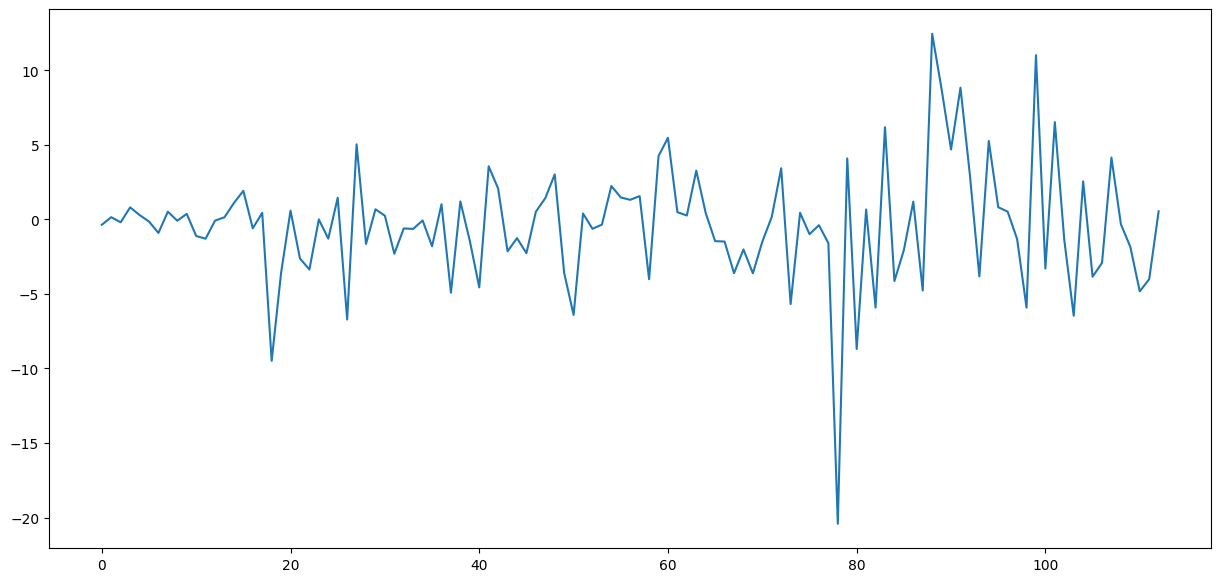

In [25]:
# Create empty list
residual = []

# Append residuals
for i in range(len(test_set)):
    result = float(test_pred[i]) - float(test_set[i])
    residual.append(result)

# Plot residuals
plt.figure(figsize=(15, 7))
plt.plot(residual)
plt.show()

## Model evaluation - Density plot

<Figure size 1500x700 with 0 Axes>

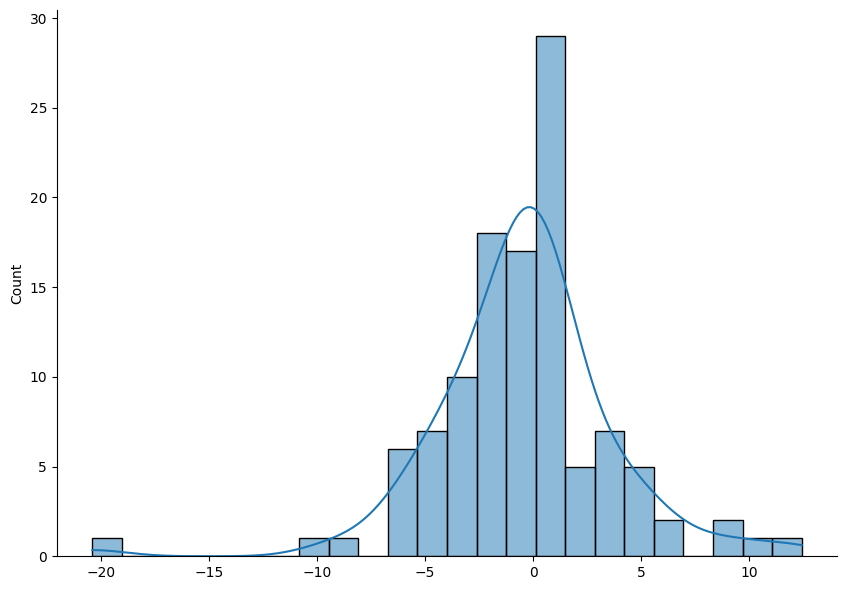

In [26]:
import seaborn as sns

# Density plot
plt.figure(figsize=(15, 7))
sns.displot(residual, kde=True, height=6, aspect=10/7)
plt.show()

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def time_series_split(df, split_ratio=0.8):
    split_idx = int(len(df) * split_ratio)

    train_df = df.iloc[:split_idx]
    test_df = df.iloc[split_idx:]

    return train_df, test_df


def time_series_arima_plot(df, split_ratio, y_hat, conf_interval, order):
    """
        Plots actual vs predicted stock prices.
    """
    train_df, test_df = time_series_split(df, split_ratio)
    plt.figure(figsize=(12, 6))

    # Actual price
    # plt.plot(train_df.index, train_df, label=f"Train Data", color="blue")
    plt.plot(test_df.index, test_df, label=f"Test Data", color="green")

    # Predicted price
    plt.plot(test_df.index, y_hat, label=f"Predicted", color="red", linestyle="dashed")
    plt.fill_between(test_df.index, conf_interval.iloc[:, 0], conf_interval.iloc[:, 1],
                     color="red", alpha=0.1, label="Confidence Interval")

     # Train-Test Split marker
    plt.axvline(x=test_df.index[0], color="black", linestyle="dashed", label="Train-Test Split")

    # Add performance metrics
    metrics = performance_metrics(test_df, y_hat)
    metrics_text = f"MSE: {metrics['MSE']:.3f}\nRMSE: {metrics['RMSE']:.3f}\nR²: {metrics['R²']:.3f}"
    plt.text(
        0.02, 0.8, metrics_text, transform=plt.gca().transAxes, fontsize=12,
        bbox=dict(facecolor="white", alpha=0.7, edgecolor="black")
    )
    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.title(f"ARIMA Price Prediction, Order: {order}")
    plt.legend(loc='lower right')
    plt.show()


def performance_metrics(y_test, y_hat):
    """
        Computes and returns model performance metrics.
    """
    return {
        "MSE": mean_squared_error(y_test, y_hat),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_hat)),
        "R²": r2_score(y_test, y_hat)
    }


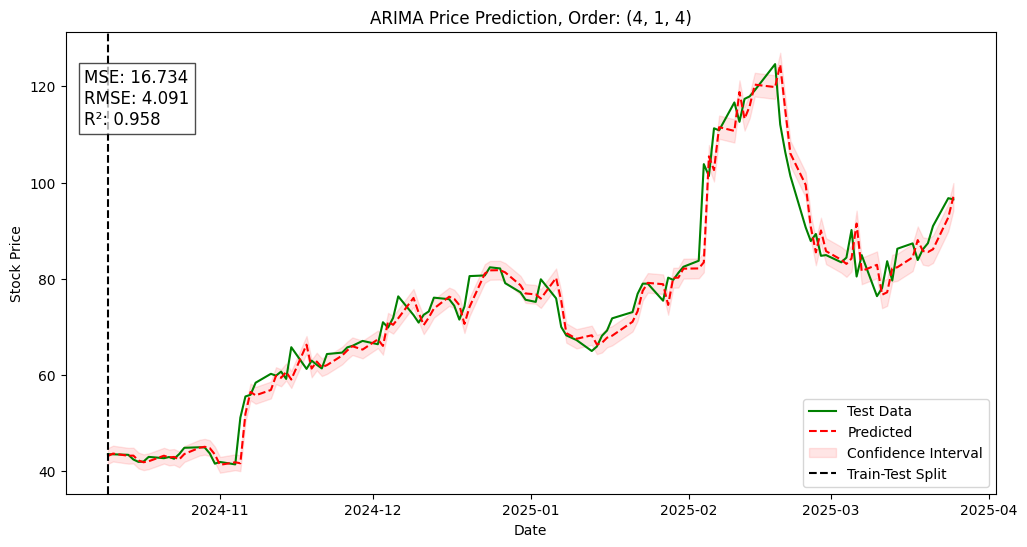

In [28]:
time_series_arima_plot(arima_df['Close'], 0.9, test_pred,
                       arima_df.loc[test_df.index,['Lower Bound', 'Upper Bound']],
                        (4,1,4))

# Strategy implementation

## Generate signal

In [29]:
# Generate signal
arima_df['Signal'] = np.where(arima_df['Prediction'] > arima_df['Close'], 1, -1)

# Calculate strategy returns
arima_df['strategy_returns'] = arima_df['Close'].pct_change() * arima_df['Signal'].shift(1)

# Drop the rows where there is NaN value
arima_df.dropna(inplace=True)

In [34]:
arima_df

,Close,High,Low,Open,Volume,Prediction,Lower Bound,Upper Bound,Signal,strategy_returns
Date,,,,,,,,,,
2024-10-10,43.520000,43.877998,42.410000,42.919998,62516300,43.158760,41.516139,44.801381,-1,-0.009042
2024-10-11,43.509998,44.380001,42.619999,43.400002,66206900,43.657140,42.015187,45.299093,1,0.000230
2024-10-14,43.400002,44.389999,43.279999,43.720001,41010900,43.203735,41.562570,44.844900,-1,-0.002528
2024-10-15,42.430000,43.680000,41.514999,43.474998,48297000,43.236012,41.595599,44.876424,1,0.022350
2024-10-16,41.930000,42.490002,40.360001,42.400002,59157900,42.222117,40.581785,43.862449,1,-0.011784
...,...,...,...,...,...,...,...,...,...,...
2025-03-19,86.099998,87.989998,82.860001,84.550003,89797400,85.774559,82.931337,88.617781,-1,0.026344
2025-03-20,87.389999,89.800003,85.120003,85.540001,105547400,85.546834,82.697575,88.396092,-1,-0.014983
2025-03-21,90.959999,91.070000,84.459999,85.849998,116748700,86.132248,83.289298,88.975197,-1,-0.040851


In [37]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

def analyse_strategy(data, test_index):
    data = data.loc[test_index]
    strategy_ret = data['strategy_returns'].dropna()
    market_ret = data['Close'].pct_change().dropna()

    # Calculate Sharpe Ratio
    sharpe_ratio = strategy_ret.mean() / strategy_ret.std() * np.sqrt(252)

    # Calculate Cumulative returns
    cumulative_returns = (strategy_ret + 1).cumprod()

    # Calculate Drawdown
    running_max = cumulative_returns.cummax()
    drawdown = 100 * (cumulative_returns / running_max - 1)
    max_dd = drawdown.min()

    # Print stats
    print(f"The Sharpe Ratio is {sharpe_ratio:.2f}")
    print(f"Cumulative Return: {(cumulative_returns.iloc[-1] - 1) * 100:.2f}%")
    print(f"Maximum Drawdown: {max_dd:.2f}%")

    # Plot drawdown
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(drawdown, color='red', label='Drawdown')
    ax.fill_between(drawdown.index, drawdown.values, color='red', alpha=0.3)
    ax.set_title('Strategy Drawdown (%)')
    ax.set_ylabel('Drawdown (%)')
    ax.set_xlabel('Date')
    ax.legend()
    plt.tight_layout()
    plt.show()

    # Plot market vs strategy
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(cumulative_returns, label="Strategy Returns", color='blue')
    ax.plot((market_ret + 1).cumprod(), label="Market Returns", linestyle='--', color='gray')
    ax.set_title('Strategy Returns vs Market Returns')
    ax.set_xlabel('Date')
    ax.set_ylabel('Cumulative Returns')
    ax.legend()
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


The Sharpe Ratio is 0.95
Cumulative Return: 22.19%
Maximum Drawdown: -43.94%


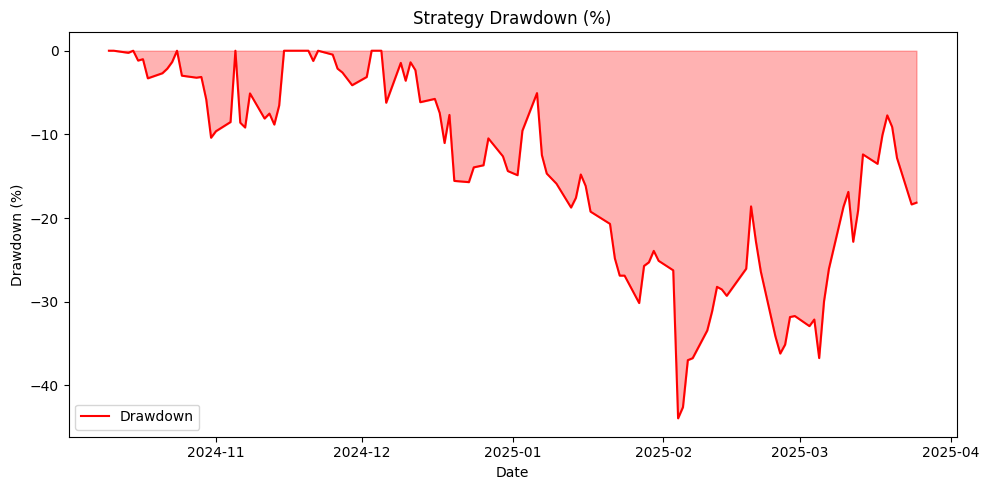

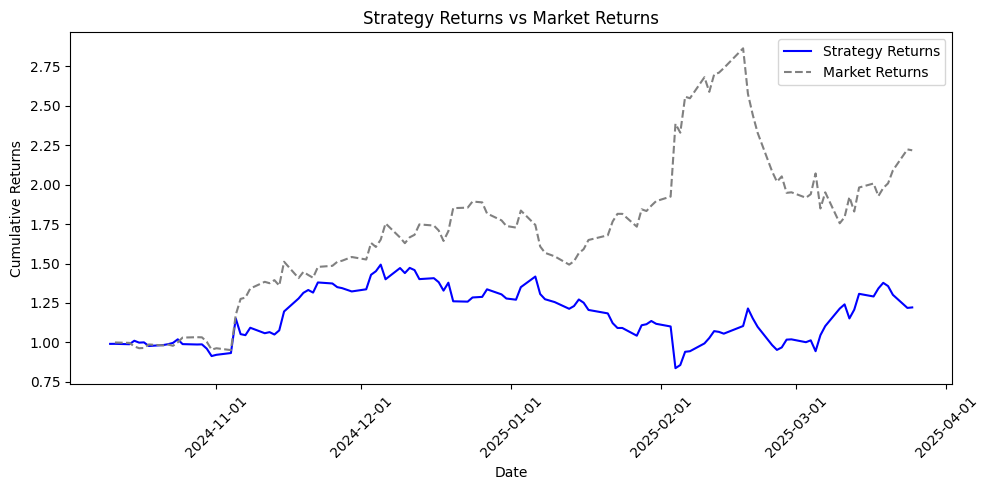

The strategy return is 22.19%


In [36]:
analyse_strategy(arima_df, test_df.index)